### Imports and definitions

In [1]:
from pickle_workaround import pickle_load
from TfidfVectorizer import TfidfVectorizer
from vectorizer import tokenize
from nlp import get_top_10_docs
from topics import search_models, plot_results
from data import get_query_corpus, get_connection

import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF

In [2]:
def topic_search(min_topics, max_topics, tfidf_corpus):

    time_start = time.time()
    costs, intertopic_similarities, interdocument_similarities = search_models(tfidf_corpus, min_topics, max_topics)
    time_dif = datetime.timedelta(seconds=round(time.time() - time_start))
    plot_results(min_topics, costs, intertopic_similarities, interdocument_similarities, time_dif, tfidf_corpus.shape)


def top10(topic_i, _W, _corpus):
    i = 1
    for doc, strength in get_top_10_docs(_W, topic_i):
        print(f"DOCUMENT #{i}")
        print("STRENGTH:", strength)
        print(_corpus[doc])
        print("*************************************************************\n")
        i += 1

In [3]:
_ = get_connection("/home/mark/Documents/missionmark/missionmark_db_creds")
tfidf = TfidfVectorizer(pickle_load("../output/CountVectorizer.pkl"), pickle_load("../output/TfidfTransformer.pkl"))

Connecting to Postgres database...
 -> Connection successful!
Loading ../output/CountVectorizer.pkl from cache...
 -> ../output/CountVectorizer.pkl loaded!
Loading ../output/TfidfTransformer.pkl from cache...
 -> ../output/TfidfTransformer.pkl loaded!


# Finding and splitting the general construction topic

### Load dataset

In [4]:
query = """SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE LENGTH(program_description) > 10
        """
doc_ids, corpus = get_query_corpus(query, True)

Loading corpus...
 -> 8847 documents loaded!


In [5]:
tfidf_corpus = tfidf.transform(corpus)

nmf = pickle_load("../output/NMF.pkl")
H = nmf.components_
W = nmf.transform(tfidf_corpus)
W_max = W.max()

Loading ../output/NMF.pkl from cache...                                         
 -> ../output/NMF.pkl loaded!


### Find topics where "hvac" is significant

In [6]:
hvac_i = tfidf.vocabulary_["hvac"]
n_hvac_topics = np.count_nonzero(H[:, hvac_i])
hvac_topics = np.argsort(H[:, hvac_i])[::-1][:n_hvac_topics]
hvac_topics_strength = H[:, hvac_i].flatten()[hvac_topics]
for topic_i, strength in zip(hvac_topics, hvac_topics_strength):
    print(topic_i, "=", strength)

26 = 0.23830234732262098
30 = 0.21730372216936295
7 = 0.16639091560822716
2 = 0.07666158724880462
20 = 0.0017088335872392868


The term "hvac" is most significant in Topic 26.  By reading the top ten documents for Topic 26, we can determine that it contains contracts for general construction tasks.
<br />
<br />

### Find other documents in Topic 26

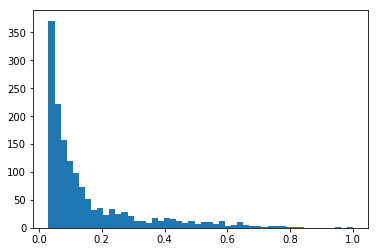

In [7]:
construction = W[:, 26]
construction /= construction.max()
_ = plt.hist(construction[construction > 0.03], bins=50)

In [8]:
threshold = .25
construction_tfidf = tfidf_corpus[construction > threshold]
construction_corpus = corpus[construction > threshold]
print(construction_tfidf.shape[0], "documents relating to construction.")

290 documents relating to construction.


### Determine the number of sub-topics to choose

Building NMF topics...
[>                                                 ]   0%         (0/98)

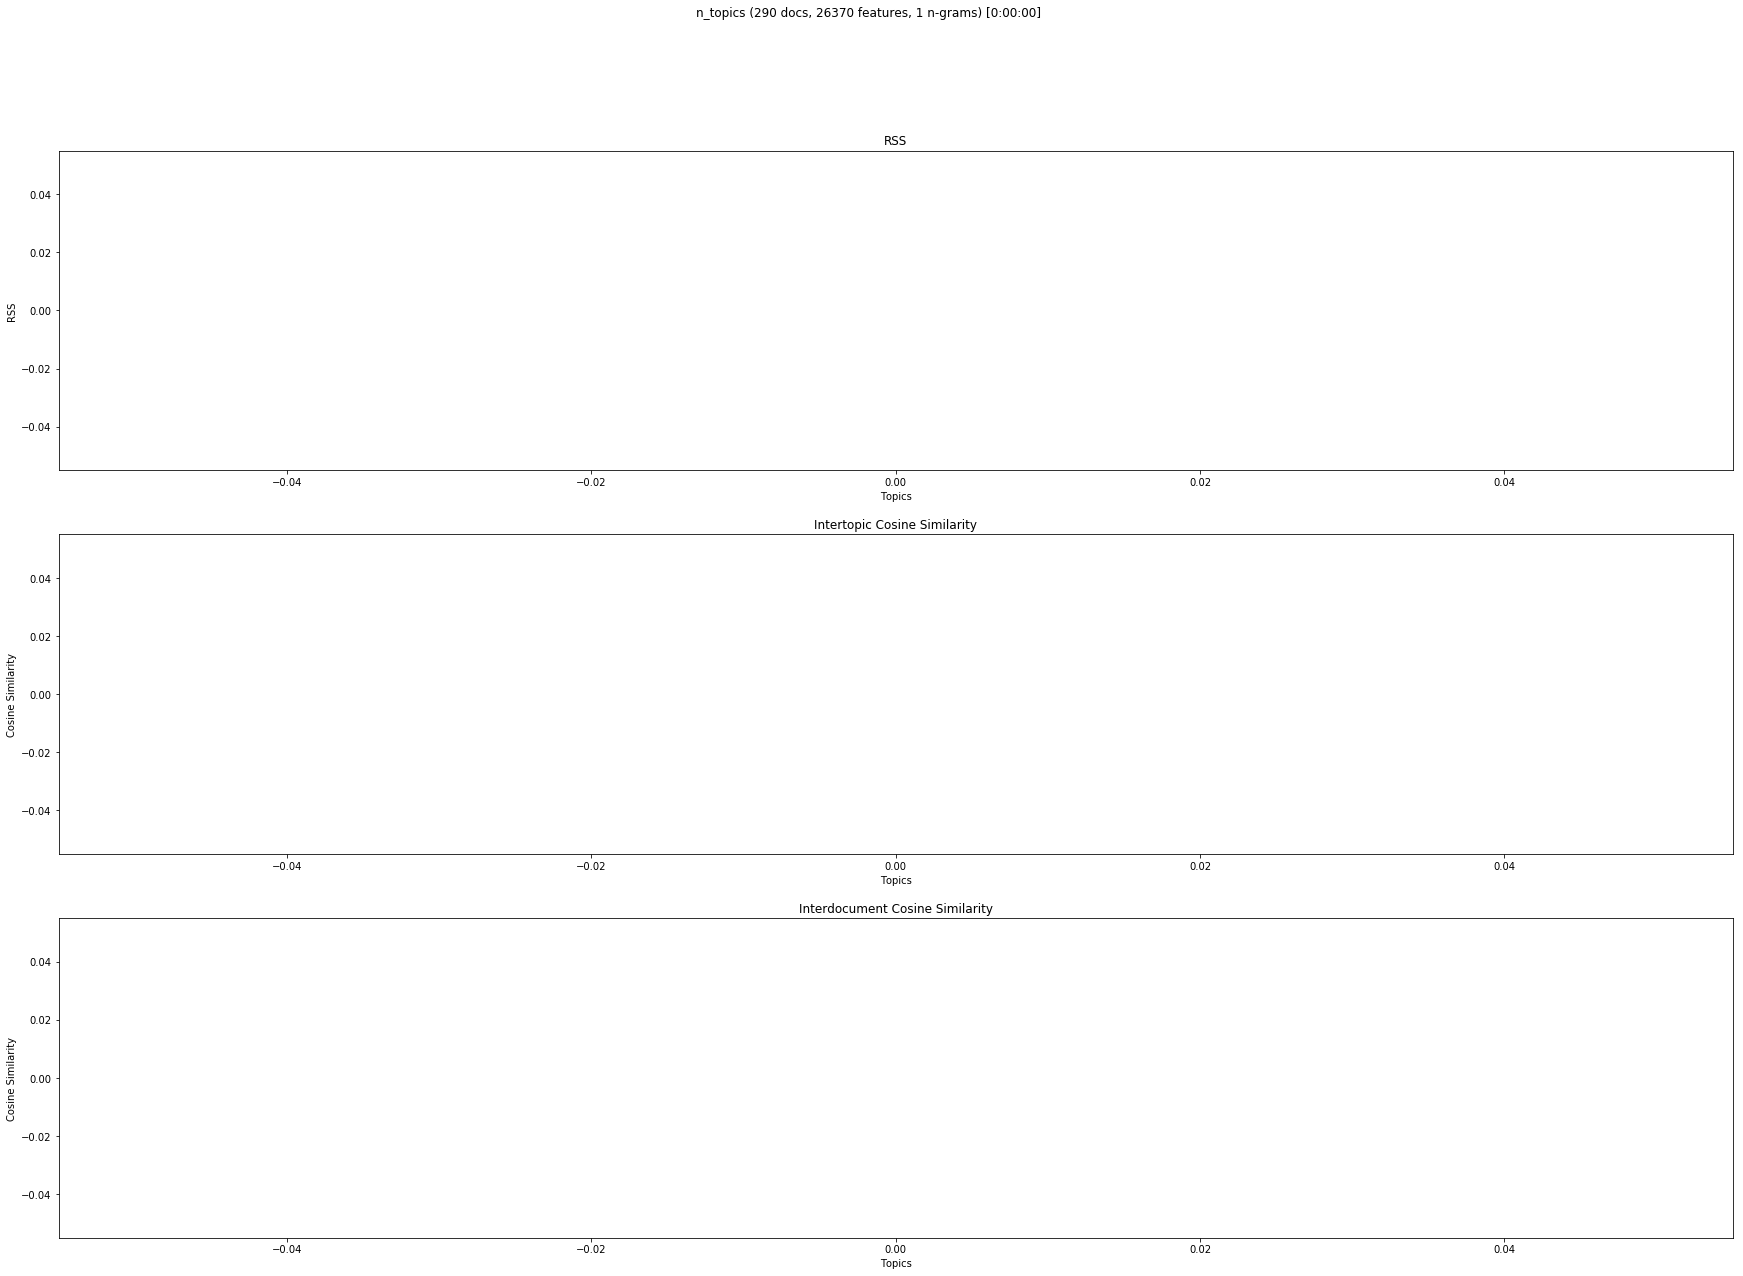

In [9]:
topic_search(3, 100, construction_tfidf)

In [10]:
construction_nmf = NMF(n_components=10, max_iter=666, random_state=666)
construction_W = construction_nmf.fit_transform(construction_tfidf)
construction_H = construction_nmf.components_
construction_W_max = construction_W.max()

In [11]:
top10(3, construction_W, construction_corpus)

DOCUMENT #1
STRENGTH: 0.5063775748531228
 The General Services Administration (GSA), Public Buildings Service (PBS) may have a continuing requirement for General Construction Services in the State of Oklahoma. BACKGROUND The landlord for the civilian federal government, Public Buildings Service (PBS) acquires space on behalf of the federal government through new construction and leasing, and acts as a caretaker for federal properties across the country. PBS owns or leases 9,624 assets, maintains an inventory of more than 370.2 million square feet of workspace for 1.1 million federal employees, and preserves more than 481 historic properties. PBS is funded primarily through the Federal Buildings Fund, which is supported by rent from federal customer agencies. PREVIOUS REQUIREMENTS  The Contractor shall provide General Construction/Repair Services to include:  Renovations  General construction services including:  Wall partition construction  Modification and alteration of floor and wall

### Find other documents in the HVAC sub-topic

In [12]:
doc_i = 2
doc = construction_corpus[doc_i]
doc_topics = construction_W[doc_i] / construction_W_max
[print(i, "->", x) for i, x in enumerate(doc_topics)]
print(doc)
construction_W.shape

0 -> 0.0015412411464525637
1 -> 0.0
2 -> 0.5482003035399684
3 -> 0.0
4 -> 0.0
5 -> 0.04046329825192404
6 -> 0.0
7 -> 0.0
8 -> 0.0
9 -> 0.04907020691358635
 The Department of the Army, Army National Guard (NGB), Utah Army National Guard (UTARNG), may have a continuing requirement for design-build (DB) construction service for maintenance, repair, construction and design-build services at Salt Lake City, Draper, West Jordan, and St. George, Utah. PREVIOUS REQUIREMENTS  Maintenance, repair, construction and design-build services at Salt Lake City, Draper, West Jordan, and St. George, Utah. Typical work includes, but is not be limited to:  Interior and exterior renovations  Heating and air-conditioning  HVAC controls  Plumbing  Fire suppression  Interior and exterior electrical and lighting  Fire and intrusion alarms  Communications  Limited utilities  Site-work  Landscaping  Fencing  Masonry  Roofing  Concrete  Asphalt paving  Storm drainage  Limited environmental remediation  Constructio

(290, 10)

# Build model from query

In [13]:
query = """
           SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description LIKE('%HVAC%')
        """
doc_ids_query, corpus_query = get_query_corpus(query, True)
tfidf_corpus_query = tfidf.transform(corpus_query)

Loading corpus...
 -> 264 documents loaded!


Building NMF topics...
[>                                                 ]   0%         (0/98)

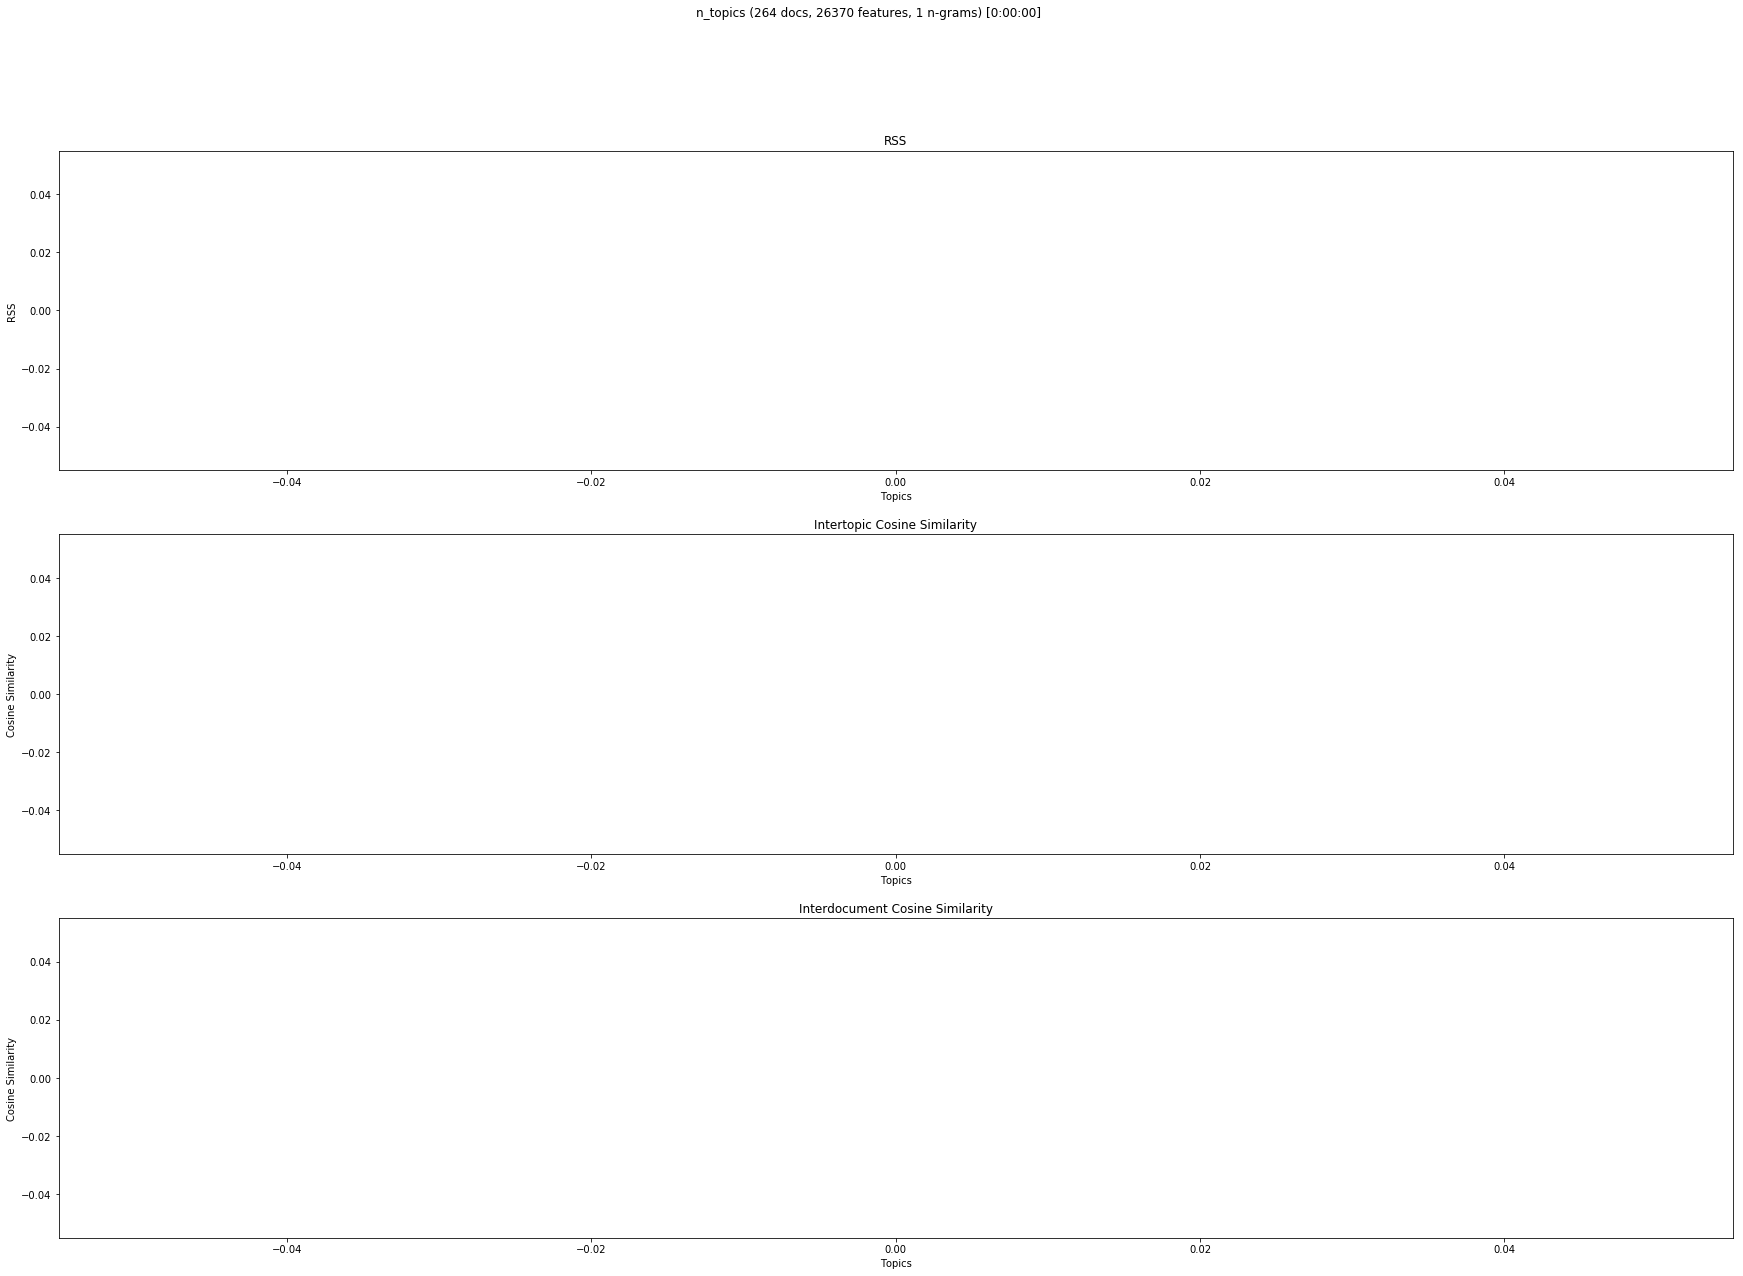

In [14]:
topic_search(3, 100, tfidf_corpus_query)

In [15]:
nmf_query = NMF(n_components=20, max_iter=666, random_state=666)
W_query = nmf_query.fit_transform(tfidf_corpus_query)
H_query = nmf_query.components_
W_max_query = W_query.max()

In [16]:
top10(5, W_query, corpus_query)

DOCUMENT #1
STRENGTH: 0.4156556699751808
 The Department of State, Bureau of Overseas Building Operations (OBO), Iraq Project Coordinating Office (IPCO) has a continuing requirement for operation and maintenance services for Baghdad New Embassy Compound (NEC). BACKGROUND The Bureau of Overseas Buildings Operations (OBO) directs the worldwide overseas buildings program for the Department of State and the U.S. Government community serving abroad under the authority of the chiefs of mission. In concert with other State Department bureaus, foreign affairs agencies, and Congress, OBO sets worldwide priorities for the design, construction, acquisition, maintenance, use, and sale of real properties and the use of sales proceeds. The NEC consists of 27 buildings, one service station, and 8 guard towers on approximately 64 acres located in the heart of Baghdad, adjacent to the Tigris River. The site is currently located within the Green Zone. Approximately 104 total acres was allocated to the U